### <b>Load Required Libraries</b>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import math
import os
import random

from types import SimpleNamespace
from scipy.fftpack import dct, idct

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80
plt.rcParams.update({'font.size': 12})

### <b>Dataset Download</b>

* CelebA Validation Dataset

In [3]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ_J1R-C2pZNk9IR4esbay0BBT1HfPximGEEDT8cpbtnCA?download=1 -O celeba_hq_validation_100.zip
!unzip celeba_hq_validation_100.zip -d ./celeba_hq_validation_100

In [4]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_dir = './celeba_hq_validation_100'
val_datasets = datasets.ImageFolder(data_dir, transforms_val)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=128, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_datasets))

class_names = val_datasets.classes
print('Class names:', class_names)

Validation dataset size: 200
Class names: ['female', 'male']


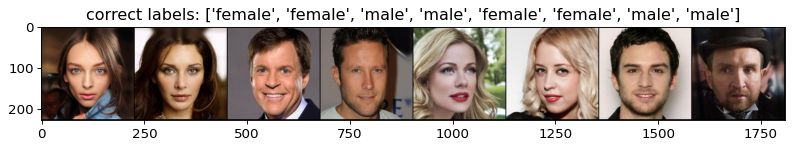

In [5]:
# display a torch image
def imshow(inputs, classes, message):
    inputs_data = inputs
    classes_data = classes
    if inputs.shape[0] > 8: # display maximum 4 images
        inputs_data = inputs[:8]
        classes_data = classes[:8]
    inputs_data = torchvision.utils.make_grid(inputs_data)
    # torch.Tensor => numpy
    inputs_data = inputs_data.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(inputs_data)
    plt.title(message + ': ' + str([class_names[x] for x in classes_data]))
    plt.show()


# visualize a batch of validation image
iterator = iter(val_dataloader)
inputs, classes = next(iterator)
imshow(inputs, classes, 'correct labels')

### <b>Load Pre-trained Classification Model</b>

* Set the model to the evaluation mode.

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1 -O classification_model.pth

--2021-03-03 23:44:49--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVd9bFWzqztMrXRDdNnCHQkBsHaM4n5_1q1fue77vtQVtw?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVmQ5YkZXenF6dE1yWFJEZE5uQ0hRa0JzSGFNNG41XzFxMWZ1ZTc3dnRRVnR3P3J0aW1lPXFldTdWWjdlMkVn [following]
--2021-03-03 23:44:49--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/face_gender_classification_transfer_learning_with_ResNet18.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvb

In [7]:
save_path = 'classification_model.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model.load_state_dict(torch.load(save_path))
model = model.cuda()
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### <b>Load Pre-trained Feature Extractor</b>

In [8]:
# VGG feature extractor
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406], device="cuda").view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device="cuda").view(-1, 1, 1)

        extractor = models.vgg16(pretrained=True).features

        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = (x - self.mean) / self.std

        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result


def extract_feature(image, feature_extractor, size):
    features = feature_extractor(F.interpolate(image, size=size))

    return features

In [9]:
feature_extractor = FeatureExtractor(n_layers=[4, 7, 14]).cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


### <b>Define Utilities</b>

In [10]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# applies the normalization transformations
def apply_normalization(imgs):
    imgs_tensor = imgs.clone()
    if imgs.dim() == 3: # color image
        for i in range(imgs_tensor.size(0)):
            imgs_tensor[i, :, :] = (imgs_tensor[i, :, :] - MEAN[i]) / STD[i]
    else: # grayscale image
        for i in range(imgs_tensor.size(1)):
            imgs_tensor[:, i, :, :] = (imgs_tensor[:, i, :, :] - MEAN[i]) / STD[i]
    return imgs_tensor


# get prediction outputs
def get_preds(model, inputs, batch_size, return_cpu=True):
    num_batches = int(math.ceil(inputs.size(0) / float(batch_size)))
    all_preds, all_probs = None, None
    for i in range(num_batches):
        upper = min((i + 1) * batch_size, inputs.size(0))
        input = apply_normalization(inputs[(i * batch_size):upper])
        with torch.no_grad():
            output = torch.nn.Softmax(dim=1)(model.forward(input.cuda()))
        prob, pred = output.max(1)
        if return_cpu:
            prob = prob.data.cpu()
            pred = pred.data.cpu()
        else:
            prob = prob.data
            pred = pred.data
        if i == 0:
            all_probs = prob
            all_preds = pred
        else:
            all_probs = torch.cat((all_probs, prob), 0)
            all_preds = torch.cat((all_preds, pred), 0)
    return all_preds, all_probs


# get low frequency noises
def sample_gaussian_torch(image_size, dct_ratio=1.0):
    x = torch.zeros(image_size)
    fill_size = int(image_size[-1] * dct_ratio)
    x[:, :, :fill_size, :fill_size] = torch.randn(x.size(0), x.size(1), fill_size, fill_size)
    if dct_ratio < 1.0:
        x = torch.from_numpy(idct(idct(x.numpy(), axis=3, norm='ortho'), axis=2, norm='ortho'))
    return x

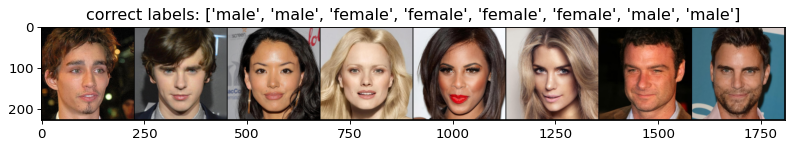

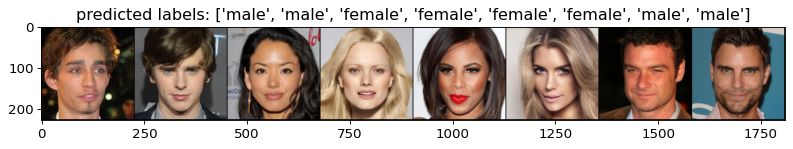

In [11]:
# visualize a batch of validation image
iterator = iter(val_dataloader)
inputs, classes = next(iterator)
imshow(inputs, classes, 'correct labels')

# visualize a prediction result
preds, _ = get_preds(model, inputs.cuda(), batch_size=8, return_cpu=False)
imshow(inputs, preds, 'predicted labels')

### <b>Boundary Attack Functions</b>

In [12]:
def boundary_attack(
    model, images, labels, init=None, max_iters=1000,
    spherical_step=0.01, source_step=0.01, step_adaptation=1.5, reset_step_every=50,
    dct_mode=True, dct_ratio=1.0):


    images = images.cuda()
    labels = labels.cuda()
    batch_size = images.size(0)
    base_preds, _ = get_preds(model, images.cuda(), batch_size=batch_size, return_cpu=False)
    images_vec = images.view(batch_size, -1)
    images_features = extract_feature(images, feature_extractor, 256)
    imshow(images.cpu(), labels, 'original labels')


    """ Prepare initial images """
    init = torch.zeros(images.size()).cuda()
    preds = labels.clone()
    while preds.eq(labels).sum() > 0:
        print("Sampling initial images")
        idx = torch.arange(0, batch_size).long().cuda()[preds.eq(labels)]
        iterator = iter(val_dataloader)
        rand_image, _ = next(iterator)
        init[idx] = rand_image[idx].cuda()
        preds, _ = get_preds(model, init, batch_size=batch_size, return_cpu=False)
    preds, _ = get_preds(model, init, batch_size=batch_size, return_cpu=False)
    perturbed = init.clone()
    print('[Initial adversairal examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')


    """ Prepare Start Points """
    min_alpha = torch.zeros(batch_size).cuda()
    max_alpha = torch.ones(batch_size).cuda()
    for _ in range(10): # binary search
        alpha = (min_alpha + max_alpha) / 2
        alpha_expanded = alpha.view(batch_size, 1, 1, 1).expand_as(init)
        interp = alpha_expanded * init + (1 - alpha_expanded) * images
        preds, _ = get_preds(model, interp, batch_size=batch_size, return_cpu=False)
        min_alpha[preds.eq(labels)] = alpha[preds.eq(labels)]
        max_alpha[preds.ne(labels)] = alpha[preds.ne(labels)]
        perturbed[preds.ne(labels)] = interp[preds.ne(labels)] # untargeted attack (label should be not equal)
    print('[Start points]')
    preds, _ = get_preds(model, perturbed, batch_size=batch_size, return_cpu=False)
    imshow(perturbed.cpu(), preds, 'predicted labels')


    """ Attack Start """
    # recording success rate of previous moves for adjusting step size
    spherical_succ = torch.zeros(batch_size, reset_step_every).cuda()
    source_succ = torch.zeros(batch_size, reset_step_every).cuda()
    spherical_steps = (torch.ones(batch_size) * spherical_step).cuda()
    source_steps = (torch.ones(batch_size) * source_step).cuda()
    
    for i in range(max_iters):
        candidates, spherical_candidates = generate_candidate(
            images, perturbed, spherical_steps, source_steps, dct_mode=dct_mode, dct_ratio=dct_ratio)
        # additional query on spherical candidate for RGB-BA
        if not dct_mode: 
            spherical_preds, _ = get_preds(model, spherical_candidates, batch_size=batch_size, return_cpu=False)
        else:
            spherical_preds = labels + 1 # Make the spherical success rate = 100%
        source_preds, _ = get_preds(model, candidates, batch_size=batch_size, return_cpu=False)
        spherical_succ[:, i % reset_step_every][spherical_preds.ne(labels)] = 1
        source_succ[:, i % reset_step_every][source_preds.ne(labels)] = 1

        # reject moves if they result incorrectly classified images
        idx = torch.arange(0, batch_size).long().cuda()[source_preds.eq(labels)] # attack fail indexes
        candidates[idx] = perturbed[idx] # then, reject
        # reject moves if MSE is already low enough
        if i > 0:
            candidates[mse_prev.lt(1e-6)] = perturbed[mse_prev.lt(1e-6)]
  
        # record current stats
        perturbed_features = extract_feature(perturbed, feature_extractor, 256)
        candidates_features = extract_feature(candidates, feature_extractor, 256)
        feature_distance_prev = 0
        feature_distance = 0
        for j in range(len(images_features)):
            feature_distance_prev += nn.MSELoss(reduction='mean')(images_features[j], perturbed_features[j])
            feature_distance += nn.MSELoss(reduction='mean')(images_features[j], candidates_features[j])
        perturbed_vec = perturbed.view(batch_size, -1)
        candidates_vec = candidates.view(batch_size, -1)
        mse_prev = (images_vec - perturbed_vec).pow(2).mean(1)
        mse = (images_vec - candidates_vec).pow(2).mean(1)
        mse_reduction = 100 * (mse_prev.mean() - mse.mean()) / mse_prev.mean()
        feature_reduction = 100 * (feature_distance_prev - feature_distance) / feature_distance_prev
        norms = (images_vec - candidates_vec).norm(2, 1)
        print('Iteration %d:  MSE = %.6f (reduced by %.4f%%), L2 norm = %.4f Feature distance = %.4f (reduced by %.4f%%)' % (i + 1, mse.mean(), mse_reduction, norms.mean(), feature_distance, feature_reduction))
        
        # adjust step size
        if (i + 1) % reset_step_every == 0:
            spherical_steps, source_steps, p_spherical, p_source = adjust_step(spherical_succ, source_succ, spherical_steps, source_steps, step_adaptation, dct_mode=dct_mode)
            spherical_succ.fill_(0)
            source_succ.fill_(0)
            print('Spherical success rate = %.4f, new spherical step = %.4f' % (p_spherical.mean(), spherical_steps.mean()))
            print('Source success rate = %.4f, new source step = %.4f' % (p_source.mean(), source_steps.mean()))

        perturbed = candidates

        if (i + 1) % 200 == 0:
            imshow(perturbed.cpu(), labels_batch, 'original labels')
            
    return perturbed.cpu()
        
    
def generate_candidate(images, perturbed, spherical_steps, source_steps, dct_mode='none', dct_ratio=1.0):
    batch_size = images.size(0)
    unnormalized_source_direction = images - perturbed
    source_norm = unnormalized_source_direction.view(batch_size, -1).norm(2, 1)
    source_direction = unnormalized_source_direction.div(source_norm.view(batch_size, 1, 1, 1).expand_as(unnormalized_source_direction))
    
    perturbation = sample_gaussian_torch(images.size(), dct_ratio=dct_ratio)
    perturbation = perturbation.cuda()
    
    if not dct_mode:
        dot = (images * perturbation).view(batch_size, -1).sum(1)
        perturbation -= source_direction.mul(dot.view(batch_size, 1, 1, 1).expand_as(source_direction))
    alpha = spherical_steps * source_norm / perturbation.view(batch_size, -1).norm(2, 1)
    perturbation = perturbation.mul(alpha.view(batch_size, 1, 1, 1).expand_as(perturbation))
    if not dct_mode:
        D = spherical_steps.pow(2).add(1).pow(-0.5)
        direction = perturbation - unnormalized_source_direction
        spherical_candidates = (images + direction.mul(D.view(batch_size, 1, 1, 1).expand_as(direction)))
    else:
        spherical_candidates = perturbed + perturbation
    spherical_candidates = spherical_candidates.clamp(0, 1)
    
    new_source_direction = images - spherical_candidates
    new_source_direction_norm = new_source_direction.view(batch_size, -1).norm(2, 1)
    length = source_steps * source_norm
    deviation = new_source_direction_norm - source_norm
    length += deviation
    length[length.le(0)] = 0
    length = length / new_source_direction_norm
    candidates = (spherical_candidates + new_source_direction.mul(length.view(batch_size, 1, 1, 1).expand_as(new_source_direction)))
    candidates = candidates.clamp(0, 1)
    
    return (candidates, spherical_candidates)


def adjust_step(spherical_succ, source_succ, spherical_steps, source_steps, step_adaptation, dct_mode='none'):
    p_spherical = spherical_succ.mean(1)
    num_spherical = spherical_succ.sum(1)
    p_source = torch.zeros(source_succ.size(0)).cuda()
    for i in range(source_succ.size(0)):
        if num_spherical[i] == 0:
            p_source[i] = 0
        else:
            p_source[i] = source_succ[i, :][spherical_succ[i].eq(1)].mean()
    if not dct_mode:
        # adjust spherical steps when using RGB-BA
        spherical_steps[p_spherical.lt(0.2)] = spherical_steps[p_spherical.lt(0.2)] / step_adaptation
        spherical_steps[p_spherical.gt(0.6)] = spherical_steps[p_spherical.gt(0.6)] * step_adaptation
    source_steps[num_spherical.ge(10) * p_source.lt(0.2)] = source_steps[num_spherical.ge(10) * p_source.lt(0.2)] / step_adaptation
    source_steps[num_spherical.ge(10) * p_source.gt(0.6)] = source_steps[num_spherical.ge(10) * p_source.gt(0.6)] * step_adaptation
    return (spherical_steps, source_steps, p_spherical, p_source)

### <b>Run Attack</b>

[Attack start]


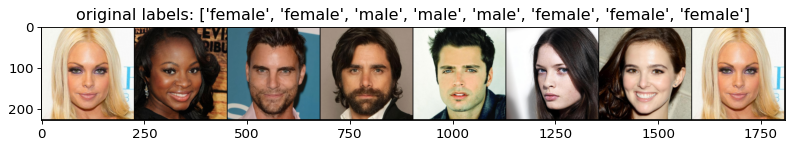

Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
[Initial adversairal examples]


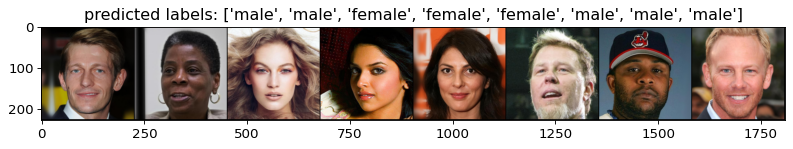

[Start points]


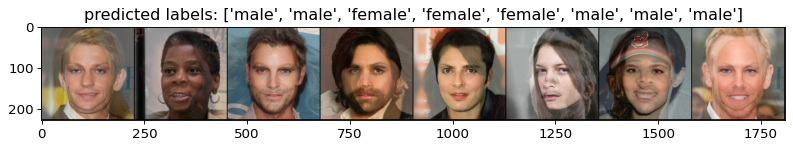

Iteration 1:  MSE = 0.040811 (reduced by 0.0507%), L2 norm = 71.0179 Feature distance = 41.8309 (reduced by 0.0420%)
Iteration 2:  MSE = 0.040743 (reduced by 0.1658%), L2 norm = 70.9792 Feature distance = 41.8142 (reduced by 0.0400%)
Iteration 3:  MSE = 0.040692 (reduced by 0.1251%), L2 norm = 70.9545 Feature distance = 41.8026 (reduced by 0.0277%)
Iteration 4:  MSE = 0.040625 (reduced by 0.1651%), L2 norm = 70.9115 Feature distance = 41.7832 (reduced by 0.0464%)
Iteration 5:  MSE = 0.040552 (reduced by 0.1813%), L2 norm = 70.8590 Feature distance = 41.7499 (reduced by 0.0798%)
Iteration 6:  MSE = 0.040501 (reduced by 0.1241%), L2 norm = 70.8299 Feature distance = 41.7379 (reduced by 0.0288%)
Iteration 7:  MSE = 0.040444 (reduced by 0.1408%), L2 norm = 70.7912 Feature distance = 41.7214 (reduced by 0.0394%)
Iteration 8:  MSE = 0.040357 (reduced by 0.2165%), L2 norm = 70.7219 Feature distance = 41.6871 (reduced by 0.0824%)
Iteration 9:  MSE = 0.040277 (reduced by 0.1983%), L2 norm = 70.

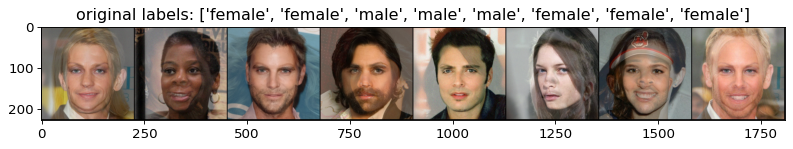

Iteration 201:  MSE = 0.032222 (reduced by 0.1247%), L2 norm = 62.7996 Feature distance = 37.8384 (reduced by 0.0393%)
Iteration 202:  MSE = 0.032201 (reduced by 0.0636%), L2 norm = 62.7724 Feature distance = 37.8234 (reduced by 0.0398%)
Iteration 203:  MSE = 0.032160 (reduced by 0.1285%), L2 norm = 62.7293 Feature distance = 37.8122 (reduced by 0.0295%)
Iteration 204:  MSE = 0.032134 (reduced by 0.0807%), L2 norm = 62.7028 Feature distance = 37.8068 (reduced by 0.0142%)
Iteration 205:  MSE = 0.032093 (reduced by 0.1269%), L2 norm = 62.6621 Feature distance = 37.7947 (reduced by 0.0319%)
Iteration 206:  MSE = 0.032057 (reduced by 0.1110%), L2 norm = 62.6226 Feature distance = 37.7810 (reduced by 0.0363%)
Iteration 207:  MSE = 0.032028 (reduced by 0.0932%), L2 norm = 62.5893 Feature distance = 37.7718 (reduced by 0.0244%)
Iteration 208:  MSE = 0.031978 (reduced by 0.1552%), L2 norm = 62.5333 Feature distance = 37.7543 (reduced by 0.0463%)
Iteration 209:  MSE = 0.031962 (reduced by 0.048

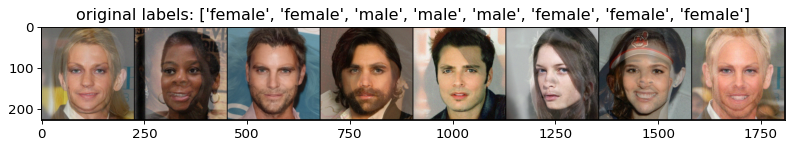

Iteration 401:  MSE = 0.026340 (reduced by 0.0517%), L2 norm = 55.8825 Feature distance = 35.4060 (reduced by 0.0294%)
Iteration 402:  MSE = 0.026300 (reduced by 0.1544%), L2 norm = 55.8392 Feature distance = 35.3970 (reduced by 0.0254%)
Iteration 403:  MSE = 0.026250 (reduced by 0.1887%), L2 norm = 55.7769 Feature distance = 35.3752 (reduced by 0.0616%)
Iteration 404:  MSE = 0.026215 (reduced by 0.1345%), L2 norm = 55.7400 Feature distance = 35.3721 (reduced by 0.0090%)
Iteration 405:  MSE = 0.026193 (reduced by 0.0849%), L2 norm = 55.7064 Feature distance = 35.3657 (reduced by 0.0180%)
Iteration 406:  MSE = 0.026186 (reduced by 0.0258%), L2 norm = 55.6990 Feature distance = 35.3693 (reduced by -0.0101%)
Iteration 407:  MSE = 0.026170 (reduced by 0.0624%), L2 norm = 55.6671 Feature distance = 35.3537 (reduced by 0.0441%)
Iteration 408:  MSE = 0.026136 (reduced by 0.1277%), L2 norm = 55.6236 Feature distance = 35.3412 (reduced by 0.0353%)
Iteration 409:  MSE = 0.026106 (reduced by 0.11

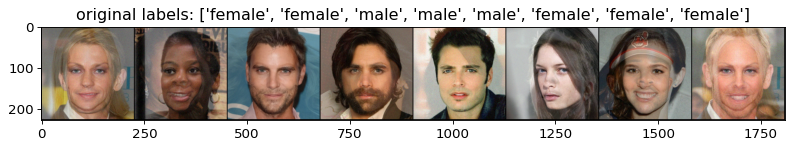

Iteration 601:  MSE = 0.022459 (reduced by 0.0634%), L2 norm = 50.9736 Feature distance = 34.0124 (reduced by 0.0317%)
Iteration 602:  MSE = 0.022439 (reduced by 0.0897%), L2 norm = 50.9542 Feature distance = 34.0158 (reduced by -0.0099%)
Iteration 603:  MSE = 0.022417 (reduced by 0.0974%), L2 norm = 50.9293 Feature distance = 34.0120 (reduced by 0.0112%)
Iteration 604:  MSE = 0.022400 (reduced by 0.0773%), L2 norm = 50.9037 Feature distance = 34.0027 (reduced by 0.0272%)
Iteration 605:  MSE = 0.022382 (reduced by 0.0764%), L2 norm = 50.8814 Feature distance = 33.9954 (reduced by 0.0216%)
Iteration 606:  MSE = 0.022367 (reduced by 0.0698%), L2 norm = 50.8664 Feature distance = 34.0060 (reduced by -0.0313%)
Iteration 607:  MSE = 0.022331 (reduced by 0.1586%), L2 norm = 50.8260 Feature distance = 33.9880 (reduced by 0.0530%)
Iteration 608:  MSE = 0.022319 (reduced by 0.0538%), L2 norm = 50.8109 Feature distance = 33.9871 (reduced by 0.0026%)
Iteration 609:  MSE = 0.022294 (reduced by 0.1

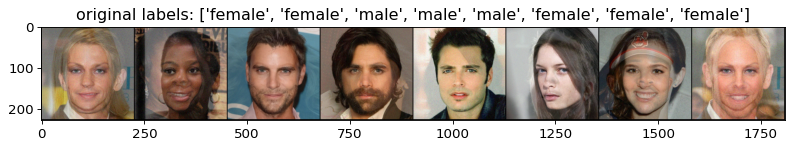

Iteration 801:  MSE = 0.019496 (reduced by 0.0884%), L2 norm = 46.9716 Feature distance = 32.7744 (reduced by 0.0216%)
Iteration 802:  MSE = 0.019486 (reduced by 0.0525%), L2 norm = 46.9568 Feature distance = 32.7724 (reduced by 0.0061%)
Iteration 803:  MSE = 0.019456 (reduced by 0.1564%), L2 norm = 46.9165 Feature distance = 32.7560 (reduced by 0.0500%)
Iteration 804:  MSE = 0.019444 (reduced by 0.0618%), L2 norm = 46.8997 Feature distance = 32.7492 (reduced by 0.0208%)
Iteration 805:  MSE = 0.019419 (reduced by 0.1270%), L2 norm = 46.8695 Feature distance = 32.7446 (reduced by 0.0142%)
Iteration 806:  MSE = 0.019411 (reduced by 0.0395%), L2 norm = 46.8577 Feature distance = 32.7384 (reduced by 0.0188%)
Iteration 807:  MSE = 0.019405 (reduced by 0.0349%), L2 norm = 46.8463 Feature distance = 32.7336 (reduced by 0.0147%)
Iteration 808:  MSE = 0.019394 (reduced by 0.0557%), L2 norm = 46.8347 Feature distance = 32.7299 (reduced by 0.0115%)
Iteration 809:  MSE = 0.019377 (reduced by 0.086

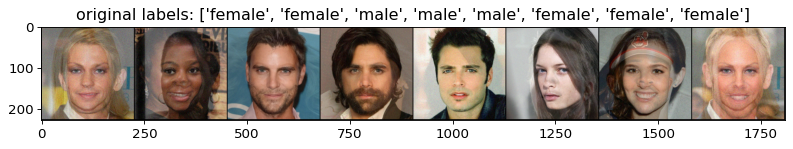

Iteration 1001:  MSE = 0.017033 (reduced by 0.0663%), L2 norm = 43.5270 Feature distance = 31.7685 (reduced by 0.0324%)
Iteration 1002:  MSE = 0.017013 (reduced by 0.1166%), L2 norm = 43.5000 Feature distance = 31.7570 (reduced by 0.0362%)
Iteration 1003:  MSE = 0.016999 (reduced by 0.0816%), L2 norm = 43.4797 Feature distance = 31.7514 (reduced by 0.0179%)
Iteration 1004:  MSE = 0.016994 (reduced by 0.0292%), L2 norm = 43.4713 Feature distance = 31.7507 (reduced by 0.0022%)
Iteration 1005:  MSE = 0.016981 (reduced by 0.0745%), L2 norm = 43.4496 Feature distance = 31.7393 (reduced by 0.0357%)
Iteration 1006:  MSE = 0.016971 (reduced by 0.0600%), L2 norm = 43.4339 Feature distance = 31.7354 (reduced by 0.0122%)
Iteration 1007:  MSE = 0.016964 (reduced by 0.0411%), L2 norm = 43.4245 Feature distance = 31.7319 (reduced by 0.0113%)
Iteration 1008:  MSE = 0.016948 (reduced by 0.0932%), L2 norm = 43.4019 Feature distance = 31.7303 (reduced by 0.0049%)
Iteration 1009:  MSE = 0.016933 (reduced

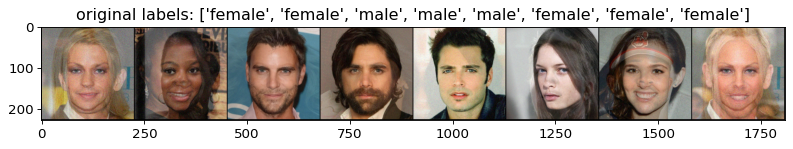

Iteration 1201:  MSE = 0.015054 (reduced by 0.0603%), L2 norm = 40.5422 Feature distance = 31.0119 (reduced by 0.0081%)
Iteration 1202:  MSE = 0.015037 (reduced by 0.1096%), L2 norm = 40.5209 Feature distance = 31.0032 (reduced by 0.0280%)
Iteration 1203:  MSE = 0.015034 (reduced by 0.0220%), L2 norm = 40.5151 Feature distance = 31.0029 (reduced by 0.0009%)
Iteration 1204:  MSE = 0.015026 (reduced by 0.0487%), L2 norm = 40.4990 Feature distance = 30.9944 (reduced by 0.0274%)
Iteration 1205:  MSE = 0.015013 (reduced by 0.0927%), L2 norm = 40.4788 Feature distance = 30.9896 (reduced by 0.0155%)
Iteration 1206:  MSE = 0.015007 (reduced by 0.0404%), L2 norm = 40.4689 Feature distance = 30.9886 (reduced by 0.0032%)
Iteration 1207:  MSE = 0.014999 (reduced by 0.0506%), L2 norm = 40.4557 Feature distance = 30.9813 (reduced by 0.0236%)
Iteration 1208:  MSE = 0.014989 (reduced by 0.0632%), L2 norm = 40.4411 Feature distance = 30.9768 (reduced by 0.0145%)
Iteration 1209:  MSE = 0.014980 (reduced

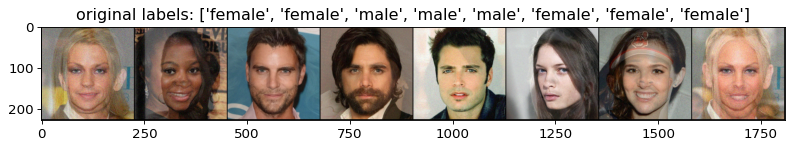

Iteration 1401:  MSE = 0.013354 (reduced by 0.0294%), L2 norm = 37.7711 Feature distance = 30.2811 (reduced by 0.0050%)
Iteration 1402:  MSE = 0.013345 (reduced by 0.0700%), L2 norm = 37.7561 Feature distance = 30.2862 (reduced by -0.0166%)
Iteration 1403:  MSE = 0.013340 (reduced by 0.0405%), L2 norm = 37.7460 Feature distance = 30.2856 (reduced by 0.0019%)
Iteration 1404:  MSE = 0.013326 (reduced by 0.0990%), L2 norm = 37.7255 Feature distance = 30.2765 (reduced by 0.0300%)
Iteration 1405:  MSE = 0.013324 (reduced by 0.0196%), L2 norm = 37.7199 Feature distance = 30.2754 (reduced by 0.0036%)
Iteration 1406:  MSE = 0.013318 (reduced by 0.0397%), L2 norm = 37.7088 Feature distance = 30.2697 (reduced by 0.0189%)
Iteration 1407:  MSE = 0.013308 (reduced by 0.0750%), L2 norm = 37.6952 Feature distance = 30.2623 (reduced by 0.0246%)
Iteration 1408:  MSE = 0.013301 (reduced by 0.0532%), L2 norm = 37.6852 Feature distance = 30.2578 (reduced by 0.0148%)
Iteration 1409:  MSE = 0.013293 (reduce

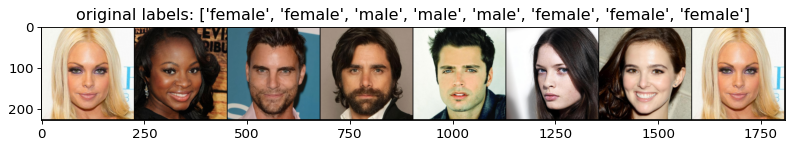

[Attack result examples]


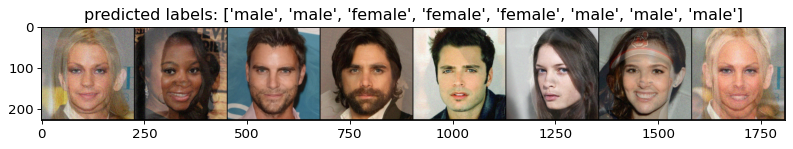

In [15]:
args = SimpleNamespace()
args.data_root = './celeba_hq_validation_100' # the root directory of a dataset
args.num_runs = 64 # number of repeated runs (number of images)
args.batch_size = 64 # batch size for parallel runs
args.num_steps = 1500 # maximum number of iterations (number of queries)
args.perturb_mode = 'gaussian' # type of spherical perturbation sample (gaussian / dct)
args.spherical_step = 0.01 # spherical step size
args.source_step = 0.01 # source step size
args.dct_ratio = 1.0 # ratio of nonzero frequencies for dct

dct_mode = (args.perturb_mode == 'dct')

# load previously sampled set of images
testset = datasets.ImageFolder(args.data_root, transforms_val)
images = torch.zeros(args.num_runs, 3, 224, 224)
labels = torch.zeros(args.num_runs).long()
preds = labels + 1

# sample a new set of images that are correctly classified
while preds.ne(labels).sum() > 0:
    idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
    for i in list(idx):
        images[i], labels[i] = testset[random.randint(0, len(testset) - 1)] # you can apply fixed seed
    preds[idx], _ = get_preds(model, images[idx], batch_size=args.batch_size)

# start attack
N = int(math.floor(float(args.num_runs) / float(args.batch_size)))
for i in range(N):
    print("==============================================================")
    print('[Attack start]')
    upper = min((i + 1) * args.batch_size, args.num_runs)
    images_batch = images[(i * args.batch_size):upper]
    labels_batch = labels[(i * args.batch_size):upper]
    perturbed = boundary_attack(
        model, images_batch, labels_batch, max_iters=args.num_steps,
        spherical_step=args.spherical_step, source_step=args.source_step,
        dct_mode=dct_mode, dct_ratio=args.dct_ratio)

    print('[Original examples]')
    imshow(images_batch.cpu(), labels_batch, 'original labels')

    preds, _ = get_preds(model, perturbed, batch_size=args.batch_size, return_cpu=False)
    print('[Attack result examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')

[Attack start]


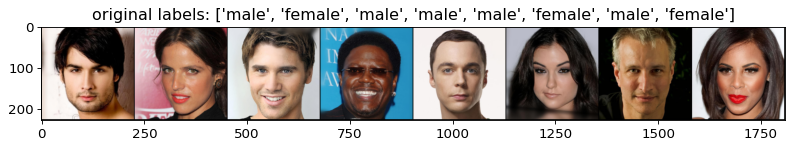

Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
Sampling initial images
[Initial adversairal examples]


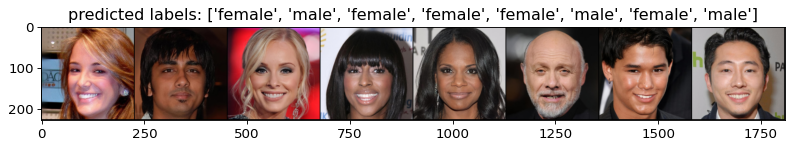

[Start points]


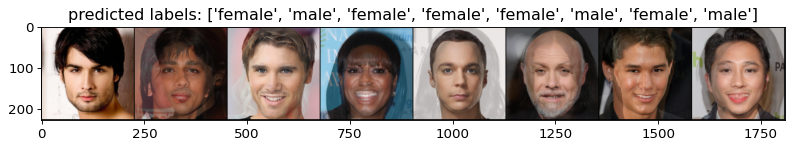

Iteration 1:  MSE = 0.042565 (reduced by 0.8089%), L2 norm = 73.0477 Feature distance = 43.3600 (reduced by 0.2849%)
Iteration 2:  MSE = 0.042227 (reduced by 0.7932%), L2 norm = 72.7846 Feature distance = 43.2506 (reduced by 0.2522%)
Iteration 3:  MSE = 0.041852 (reduced by 0.8881%), L2 norm = 72.5044 Feature distance = 43.1172 (reduced by 0.3084%)
Iteration 4:  MSE = 0.041494 (reduced by 0.8559%), L2 norm = 72.2262 Feature distance = 42.9885 (reduced by 0.2985%)
Iteration 5:  MSE = 0.041064 (reduced by 1.0355%), L2 norm = 71.8786 Feature distance = 42.7939 (reduced by 0.4527%)
Iteration 6:  MSE = 0.040654 (reduced by 0.9997%), L2 norm = 71.5666 Feature distance = 42.6425 (reduced by 0.3538%)
Iteration 7:  MSE = 0.040234 (reduced by 1.0338%), L2 norm = 71.2190 Feature distance = 42.4509 (reduced by 0.4493%)
Iteration 8:  MSE = 0.039866 (reduced by 0.9142%), L2 norm = 70.9324 Feature distance = 42.3039 (reduced by 0.3462%)
Iteration 9:  MSE = 0.039493 (reduced by 0.9348%), L2 norm = 70.

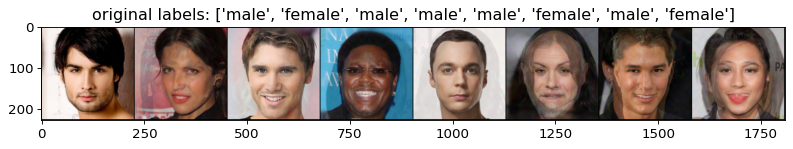

Iteration 201:  MSE = 0.017794 (reduced by 0.5158%), L2 norm = 47.3776 Feature distance = 29.1177 (reduced by 0.2218%)
Iteration 202:  MSE = 0.017739 (reduced by 0.3136%), L2 norm = 47.3050 Feature distance = 29.0810 (reduced by 0.1259%)
Iteration 203:  MSE = 0.017647 (reduced by 0.5152%), L2 norm = 47.2023 Feature distance = 29.0338 (reduced by 0.1623%)
Iteration 204:  MSE = 0.017577 (reduced by 0.3988%), L2 norm = 47.1128 Feature distance = 28.9887 (reduced by 0.1554%)
Iteration 205:  MSE = 0.017528 (reduced by 0.2757%), L2 norm = 47.0496 Feature distance = 28.9528 (reduced by 0.1240%)
Iteration 206:  MSE = 0.017464 (reduced by 0.3650%), L2 norm = 46.9673 Feature distance = 28.9055 (reduced by 0.1631%)
Iteration 207:  MSE = 0.017408 (reduced by 0.3225%), L2 norm = 46.8966 Feature distance = 28.8752 (reduced by 0.1050%)
Iteration 208:  MSE = 0.017358 (reduced by 0.2904%), L2 norm = 46.8215 Feature distance = 28.8441 (reduced by 0.1075%)
Iteration 209:  MSE = 0.017281 (reduced by 0.441

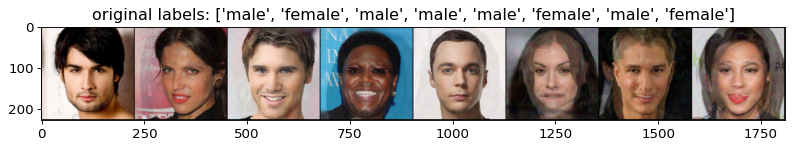

Iteration 401:  MSE = 0.010359 (reduced by 0.2768%), L2 norm = 36.0173 Feature distance = 23.1256 (reduced by 0.1337%)
Iteration 402:  MSE = 0.010329 (reduced by 0.2892%), L2 norm = 35.9659 Feature distance = 23.0973 (reduced by 0.1221%)
Iteration 403:  MSE = 0.010311 (reduced by 0.1752%), L2 norm = 35.9328 Feature distance = 23.0783 (reduced by 0.0821%)
Iteration 404:  MSE = 0.010281 (reduced by 0.2915%), L2 norm = 35.8781 Feature distance = 23.0474 (reduced by 0.1339%)
Iteration 405:  MSE = 0.010262 (reduced by 0.1820%), L2 norm = 35.8415 Feature distance = 23.0278 (reduced by 0.0852%)
Iteration 406:  MSE = 0.010233 (reduced by 0.2821%), L2 norm = 35.7865 Feature distance = 22.9986 (reduced by 0.1267%)
Iteration 407:  MSE = 0.010207 (reduced by 0.2535%), L2 norm = 35.7423 Feature distance = 22.9762 (reduced by 0.0975%)
Iteration 408:  MSE = 0.010182 (reduced by 0.2501%), L2 norm = 35.6968 Feature distance = 22.9547 (reduced by 0.0937%)
Iteration 409:  MSE = 0.010158 (reduced by 0.229

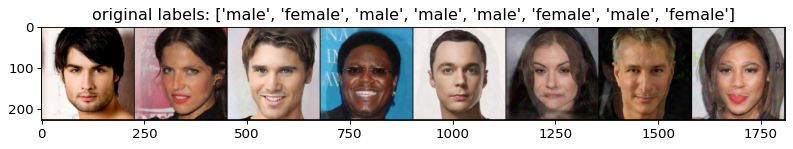

Iteration 601:  MSE = 0.006670 (reduced by 0.2064%), L2 norm = 28.6562 Feature distance = 18.8567 (reduced by 0.0798%)
Iteration 602:  MSE = 0.006652 (reduced by 0.2785%), L2 norm = 28.6193 Feature distance = 18.8308 (reduced by 0.1373%)
Iteration 603:  MSE = 0.006639 (reduced by 0.1857%), L2 norm = 28.5916 Feature distance = 18.8151 (reduced by 0.0835%)
Iteration 604:  MSE = 0.006626 (reduced by 0.2003%), L2 norm = 28.5635 Feature distance = 18.7952 (reduced by 0.1061%)
Iteration 605:  MSE = 0.006614 (reduced by 0.1833%), L2 norm = 28.5393 Feature distance = 18.7825 (reduced by 0.0673%)
Iteration 606:  MSE = 0.006597 (reduced by 0.2566%), L2 norm = 28.5047 Feature distance = 18.7612 (reduced by 0.1136%)
Iteration 607:  MSE = 0.006580 (reduced by 0.2626%), L2 norm = 28.4712 Feature distance = 18.7406 (reduced by 0.1098%)
Iteration 608:  MSE = 0.006561 (reduced by 0.2774%), L2 norm = 28.4282 Feature distance = 18.7154 (reduced by 0.1343%)
Iteration 609:  MSE = 0.006546 (reduced by 0.226

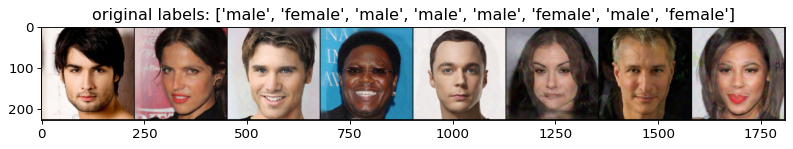

Iteration 801:  MSE = 0.004599 (reduced by 0.1722%), L2 norm = 23.6590 Feature distance = 15.8554 (reduced by 0.0985%)
Iteration 802:  MSE = 0.004592 (reduced by 0.1508%), L2 norm = 23.6420 Feature distance = 15.8455 (reduced by 0.0620%)
Iteration 803:  MSE = 0.004588 (reduced by 0.1031%), L2 norm = 23.6298 Feature distance = 15.8395 (reduced by 0.0380%)
Iteration 804:  MSE = 0.004581 (reduced by 0.1452%), L2 norm = 23.6126 Feature distance = 15.8292 (reduced by 0.0652%)
Iteration 805:  MSE = 0.004572 (reduced by 0.2071%), L2 norm = 23.5909 Feature distance = 15.8144 (reduced by 0.0934%)
Iteration 806:  MSE = 0.004568 (reduced by 0.0711%), L2 norm = 23.5795 Feature distance = 15.8085 (reduced by 0.0372%)
Iteration 807:  MSE = 0.004563 (reduced by 0.1204%), L2 norm = 23.5628 Feature distance = 15.7967 (reduced by 0.0744%)
Iteration 808:  MSE = 0.004557 (reduced by 0.1291%), L2 norm = 23.5463 Feature distance = 15.7846 (reduced by 0.0768%)
Iteration 809:  MSE = 0.004550 (reduced by 0.157

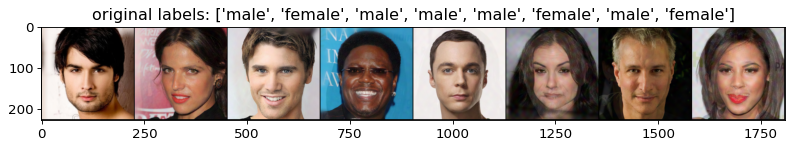

Iteration 1001:  MSE = 0.003370 (reduced by 0.2078%), L2 norm = 20.1486 Feature distance = 13.6587 (reduced by 0.0975%)
Iteration 1002:  MSE = 0.003365 (reduced by 0.1608%), L2 norm = 20.1322 Feature distance = 13.6473 (reduced by 0.0832%)
Iteration 1003:  MSE = 0.003360 (reduced by 0.1501%), L2 norm = 20.1169 Feature distance = 13.6363 (reduced by 0.0807%)
Iteration 1004:  MSE = 0.003353 (reduced by 0.2150%), L2 norm = 20.0967 Feature distance = 13.6231 (reduced by 0.0973%)
Iteration 1005:  MSE = 0.003348 (reduced by 0.1358%), L2 norm = 20.0833 Feature distance = 13.6161 (reduced by 0.0508%)
Iteration 1006:  MSE = 0.003344 (reduced by 0.1097%), L2 norm = 20.0703 Feature distance = 13.6061 (reduced by 0.0736%)
Iteration 1007:  MSE = 0.003341 (reduced by 0.0976%), L2 norm = 20.0606 Feature distance = 13.6001 (reduced by 0.0439%)
Iteration 1008:  MSE = 0.003337 (reduced by 0.1250%), L2 norm = 20.0471 Feature distance = 13.5920 (reduced by 0.0601%)
Iteration 1009:  MSE = 0.003333 (reduced

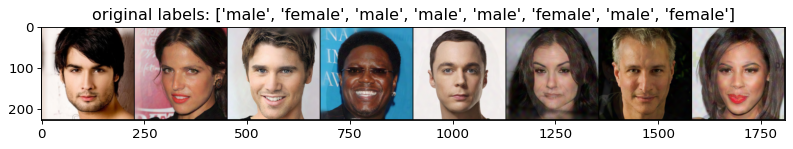

Iteration 1201:  MSE = 0.002579 (reduced by 0.1445%), L2 norm = 17.5219 Feature distance = 11.9650 (reduced by 0.0898%)
Iteration 1202:  MSE = 0.002576 (reduced by 0.1179%), L2 norm = 17.5104 Feature distance = 11.9562 (reduced by 0.0739%)
Iteration 1203:  MSE = 0.002572 (reduced by 0.1612%), L2 norm = 17.4957 Feature distance = 11.9493 (reduced by 0.0575%)
Iteration 1204:  MSE = 0.002569 (reduced by 0.0998%), L2 norm = 17.4853 Feature distance = 11.9424 (reduced by 0.0580%)
Iteration 1205:  MSE = 0.002566 (reduced by 0.1246%), L2 norm = 17.4738 Feature distance = 11.9321 (reduced by 0.0859%)
Iteration 1206:  MSE = 0.002564 (reduced by 0.0752%), L2 norm = 17.4648 Feature distance = 11.9242 (reduced by 0.0665%)
Iteration 1207:  MSE = 0.002560 (reduced by 0.1592%), L2 norm = 17.4492 Feature distance = 11.9115 (reduced by 0.1063%)
Iteration 1208:  MSE = 0.002557 (reduced by 0.1259%), L2 norm = 17.4378 Feature distance = 11.9044 (reduced by 0.0594%)
Iteration 1209:  MSE = 0.002553 (reduced

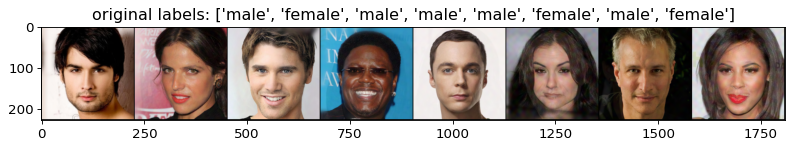

Iteration 1401:  MSE = 0.001974 (reduced by 0.1140%), L2 norm = 15.2819 Feature distance = 10.5201 (reduced by 0.0725%)
Iteration 1402:  MSE = 0.001971 (reduced by 0.1359%), L2 norm = 15.2715 Feature distance = 10.5139 (reduced by 0.0596%)
Iteration 1403:  MSE = 0.001969 (reduced by 0.1005%), L2 norm = 15.2630 Feature distance = 10.5075 (reduced by 0.0604%)
Iteration 1404:  MSE = 0.001967 (reduced by 0.1295%), L2 norm = 15.2525 Feature distance = 10.5014 (reduced by 0.0584%)
Iteration 1405:  MSE = 0.001964 (reduced by 0.1142%), L2 norm = 15.2427 Feature distance = 10.4957 (reduced by 0.0539%)
Iteration 1406:  MSE = 0.001962 (reduced by 0.1157%), L2 norm = 15.2327 Feature distance = 10.4892 (reduced by 0.0624%)
Iteration 1407:  MSE = 0.001959 (reduced by 0.1503%), L2 norm = 15.2213 Feature distance = 10.4808 (reduced by 0.0794%)
Iteration 1408:  MSE = 0.001957 (reduced by 0.1149%), L2 norm = 15.2117 Feature distance = 10.4749 (reduced by 0.0563%)
Iteration 1409:  MSE = 0.001954 (reduced

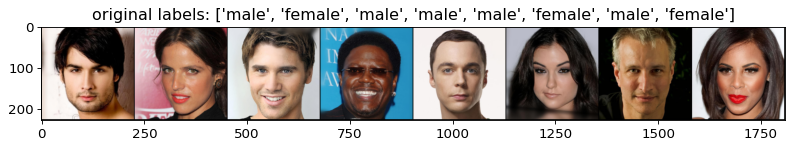

[Attack result examples]


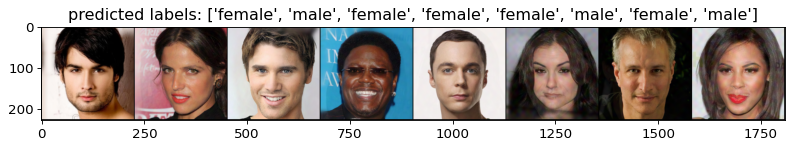

In [14]:
args = SimpleNamespace()
args.data_root = './celeba_hq_validation_100' # the root directory of a dataset
args.num_runs = 64 # number of repeated runs (number of images)
args.batch_size = 64 # batch size for parallel runs
args.num_steps = 1500 # maximum number of iterations (number of queries)
args.perturb_mode = 'dct' # type of spherical perturbation sample (gaussian / dct)
args.spherical_step = 0.01 # spherical step size
args.source_step = 0.01 # source step size
args.dct_ratio = 0.125 # ratio of nonzero frequencies for dct

dct_mode = (args.perturb_mode == 'dct')

# load previously sampled set of images
testset = datasets.ImageFolder(args.data_root, transforms_val)
images = torch.zeros(args.num_runs, 3, 224, 224)
labels = torch.zeros(args.num_runs).long()
preds = labels + 1

# sample a new set of images that are correctly classified
while preds.ne(labels).sum() > 0:
    idx = torch.arange(0, images.size(0)).long()[preds.ne(labels)]
    for i in list(idx):
        images[i], labels[i] = testset[random.randint(0, len(testset) - 1)] # you can apply fixed seed
    preds[idx], _ = get_preds(model, images[idx], batch_size=args.batch_size)

# start attack
N = int(math.floor(float(args.num_runs) / float(args.batch_size)))
for i in range(N):
    print("==============================================================")
    print('[Attack start]')
    upper = min((i + 1) * args.batch_size, args.num_runs)
    images_batch = images[(i * args.batch_size):upper]
    labels_batch = labels[(i * args.batch_size):upper]
    perturbed = boundary_attack(
        model, images_batch, labels_batch, max_iters=args.num_steps,
        spherical_step=args.spherical_step, source_step=args.source_step,
        dct_mode=dct_mode, dct_ratio=args.dct_ratio)

    print('[Original examples]')
    imshow(images_batch.cpu(), labels_batch, 'original labels')

    preds, _ = get_preds(model, perturbed, batch_size=8, return_cpu=False)
    print('[Attack result examples]')
    imshow(perturbed.cpu(), preds, 'predicted labels')